# Exoplanet Habitability

According to Wikipedia, the key goals of the Kepler Space Telescope are:

- To determine how many Earth-size and larger planets there are in or near the habitable zone (often called "Goldilocks planets") of a wide variety of spectral types of stars.
- To determine the range of size and shape of the orbits of these planets.
- To estimate how many planets there are in multiple-star systems.
- To determine the range of orbit size, brightness, size, mass and density of short-period giant planets.
- To identify additional members of each discovered planetary system using other techniques.
- Determine the properties of those stars that harbor planetary systems.

In [1]:
# Python imports and settings
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pydash import py_ as _

from src.dataset_koi import koi, koi_columns, koi_column_types
from src.utilities import onehot_encode_comments

# https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_rows', 8)  # 8 is required for .describe()

%load_ext autoreload
%autoreload 2

In [2]:
dataset = (
    pd.concat([
        koi['archive'],
        koi['KIC'][['ra','dec']],
        koi['transit'],       
        koi['stellar'],
    ], axis=1)
    .sort_values(by='koi_disposition')
    .query('koi_disposition == "CONFIRMED"')            
)
dataset

,kepler_name,koi_disposition,ra,dec,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_fittype,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff1,koi_ldm_coeff2,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sparprov
kepoi_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
K00490.02,Kepler-167 A e,CONFIRMED,292.65842,38.345390,1071.232624,420.286557,2455253.287,0.216,16.1784,19046.0,0.122698,2.85277,LS+MCMC,9.27,1.8600,89.98,129.0,0.07,557.300,0.6270,0.1082,4799.0,4.631,-0.02,0.692,0.776,stellar
K00697.01,Kepler-650 b,CONFIRMED,289.00089,45.154270,3.032148,171.734281,2455004.734,0.836,3.8627,488.6,0.022926,0.10012,LS+MCMC,3.62,0.0421,76.77,1507.0,1218.88,3.650,0.4133,0.2600,5827.0,4.151,0.16,1.447,1.081,stellar
K02045.03,Kepler-354 c,CONFIRMED,285.75146,41.335640,16.934810,137.250200,2454970.250,0.471,3.4080,346.3,0.017030,2.64272,LS+MCMC,1.31,0.1150,89.21,508.0,15.77,34.200,0.6270,0.1082,4650.0,4.589,-0.04,0.706,0.704,stellar
K00694.01,Kepler-648 b,CONFIRMED,283.89966,45.016891,17.421160,184.245906,2455017.246,0.651,4.9974,928.1,0.029277,0.59786,LS+MCMC,3.11,0.1341,88.24,674.0,48.91,21.250,0.4282,0.2514,5679.0,4.487,0.30,0.972,1.058,stellar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K02842.01,Kepler-446 b,CONFIRMED,282.25021,44.921108,1.565413,132.912810,2454965.913,0.003,0.7572,2754.6,0.048437,35.12423,LS+MCMC,1.73,0.0182,89.99,648.0,41.85,16.570,0.3402,0.3775,3464.0,4.923,-0.14,0.328,0.328,stellar
K02473.01,Kepler-389 b,CONFIRMED,291.95999,44.900021,3.244175,132.940140,2454965.940,0.761,1.9920,371.9,0.019378,1.09879,LS+MCMC,1.84,0.0401,84.86,1047.0,283.66,8.490,0.5820,0.1451,5094.0,4.469,0.16,0.870,0.813,stellar
K00284.03,Kepler-132 A b,CONFIRMED,283.23581,41.343040,6.178174,168.862600,2455001.863,0.775,3.2601,101.9,0.010125,0.41392,LS+MCMC,1.22,0.0643,85.28,1082.0,324.69,9.420,0.3447,0.2916,5931.0,4.322,-0.24,1.101,0.929,stellar
K00897.01,Kepler-718 b,CONFIRMED,299.56189,43.503559,2.052350,169.890622,2455002.891,0.437,2.0778,14281.0,0.111230,2.08526,LS+MCMC,13.12,0.0322,86.76,1497.0,1183.18,7.743,0.4096,0.2602,5855.0,4.393,0.14,1.080,1.049,stellar


## Calculating Mass and Density

Unfortunatly it is not possible to calcuate the mass, and by extension density, of an exoplanet using the KOI table alone.

Normally, planetary mass is caculated using the doppler-shift [Radial Velocity](https://www.planetary.org/explore/space-topics/exoplanets/radial-velocity.html) 
method. This method works by observing the gravitational wobble of the star as it orbits around the barycenter of the combined exoplanet-star system. 

Once mass has been computed, then density can be simply calcuated as the mass divided by the volume of a sphere. Density = Mass / (4/3 π r^3)

Using the Kepler Transit Method alone, it is technically possible to measure the mass of exoplanets, but only if multiple exoplanets orbit the same star. 
There exists a small gravitational tug between planets, causing a tiny measurable variation in the transit timings of each orbit, 
due to the relative position of the planets. A paper was published on the discovery of 
[The mass of the Mars-sized exoplanet Kepler-138 b from transit timing](https://www.nature.com/articles/nature14494) as 0.066 (+-0.059) Earth Masses. 

## Goldilocks Exoplanets

The first criteria for a earth-like habitable planet is liquid water, which would require a `koi_teq` Equilibrium Temperature (Kelvin) within the range 273.2K - 373.2K

We start with 2303 total CONFIRMED exoplanets, 110 have a temperature that is "just right"

In [3]:
dataset['goldilocks_temp'] = ((273.2 <= dataset['koi_teq']) & (dataset['koi_teq'] <= 373.2))
goldilocks_counts = {}
goldilocks_counts['temp'] = {
    "too cold":   dataset.query('koi_teq         <= 273.2').shape[0],
    "just right": dataset.query('goldilocks_temp == True' ).shape[0],
    "too hot":    dataset.query('koi_teq         >= 373.2').shape[0],
}
for key, value in goldilocks_counts['temp'].items():
    print( 'Exoplanets that are %-10s: %4d (%5.2f%%)' % ( key, value, 100*value/dataset.shape[0] ) )    

Exoplanets that are too cold  :   50 ( 2.17%)
Exoplanets that are just right:  110 ( 4.78%)
Exoplanets that are too hot   : 2142 (93.01%)


Lacking a formal density measurement from the KOI table, the closest proxy is `koi_prad` Planetary Radius (Earth radii). Different possible planet types include:

- [Super-Earth](https://en.wikipedia.org/wiki/Super-Earth) below 10$M_e$ with a radius of 0.8-1.25$R_e$ - exactly what we are looking for
- Earth Sized [Ocean_planet](https://en.wikipedia.org/wiki/Ocean_planet) would have a much lower density - but could potentually harbour life
- [Carbon planet](https://en.wikipedia.org/wiki/Carbon_planet) low density diamonds in the sky - may lack enough oxgyen to have water
- Gaseous [Mini-Neptunes](https://en.wikipedia.org/wiki/Mini-Neptune) require a minimum radius of 1.7$R_e$
- Small [Sub Earths](https://en.wikipedia.org/wiki/Sub-Earth) under 0.8$R_e$, likely lack the gravity and magnetic fields to sustain a habitable atmosphere

[List of potentially habitable exoplanets](https://en.wikipedia.org/wiki/List_of_potentially_habitable_exoplanets) only lists exoplanets in the range of 0.78-1.63$E_r$, which mostly agrees with the 0.8-1.7$E_r$ range suggested above

In [4]:
dataset['goldilocks_size'] = ((0.8 <= dataset['koi_prad']) & (dataset['koi_prad'] <= 1.7))
goldilocks_counts['size'] = {
    "too small":  dataset.query('koi_prad        <= 0.8' ).shape[0],
    "just right": dataset.query('goldilocks_size == True').shape[0],
    "too big":    dataset.query('koi_prad        >= 1.7' ).shape[0],
}
for key, value in goldilocks_counts['size'].items():
    print( 'Exoplanets that are %-10s: %4d (%5.2f%%)' % ( key, value, 100*value/dataset.shape[0] ) )    

Exoplanets that are too small :   56 ( 2.43%)
Exoplanets that are just right:  713 (30.96%)
Exoplanets that are too big   : 1550 (67.30%)


These limits can then be combined together 

In [5]:
dataset['goldilocks'] = ((dataset['goldilocks_temp'] == True) & (dataset['goldilocks_size'] == True))
goldilocks_counts['combined'] = {
    "just right": dataset.query('goldilocks==True').shape[0]
}

for key in goldilocks_counts.keys():
    value = goldilocks_counts[key]['just right']
    print( 'Exoplanets that are "just right" %-10s: %4d (%5.2f%%)' % ( key, value, 100*value/dataset.shape[0] ) )    

Exoplanets that are "just right" temp      :  110 ( 4.78%)
Exoplanets that are "just right" size      :  713 (30.96%)
Exoplanets that are "just right" combined  :   17 ( 0.74%)


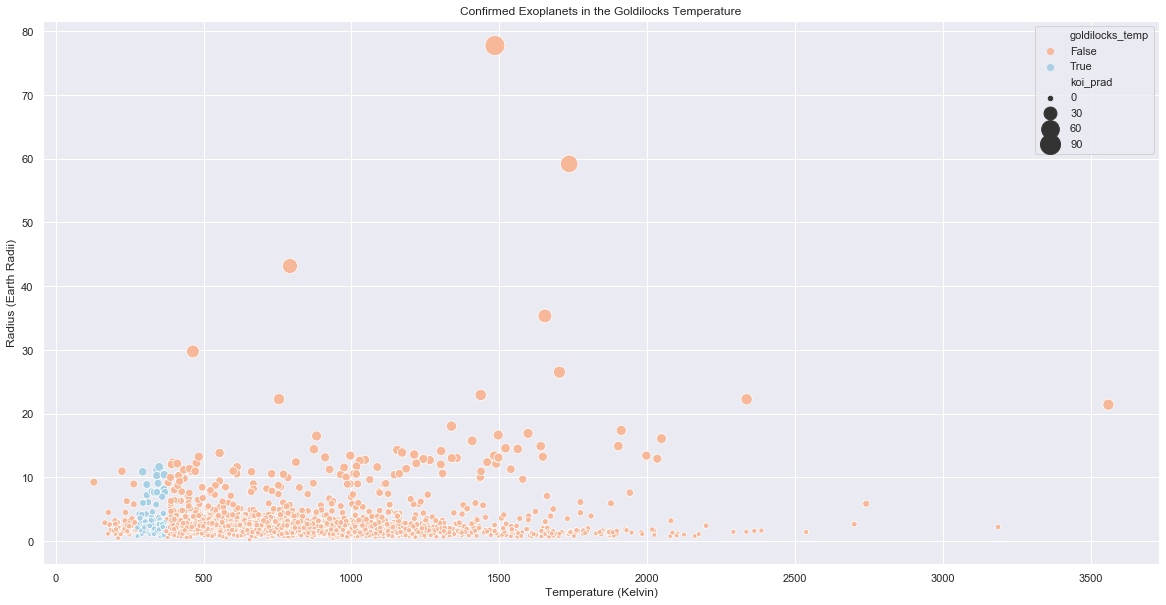

In [6]:
sns.set(rc={'figure.figsize':(20,10)})
sns.scatterplot(
    data=dataset,        
    x="koi_teq",
    y="koi_prad",
    size="koi_prad", sizes=(20,400),    
    hue="goldilocks_temp", palette="RdBu",
)
plt.title('Confirmed Exoplanets in the Goldilocks Temperature')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Radius (Earth Radii)')
display()

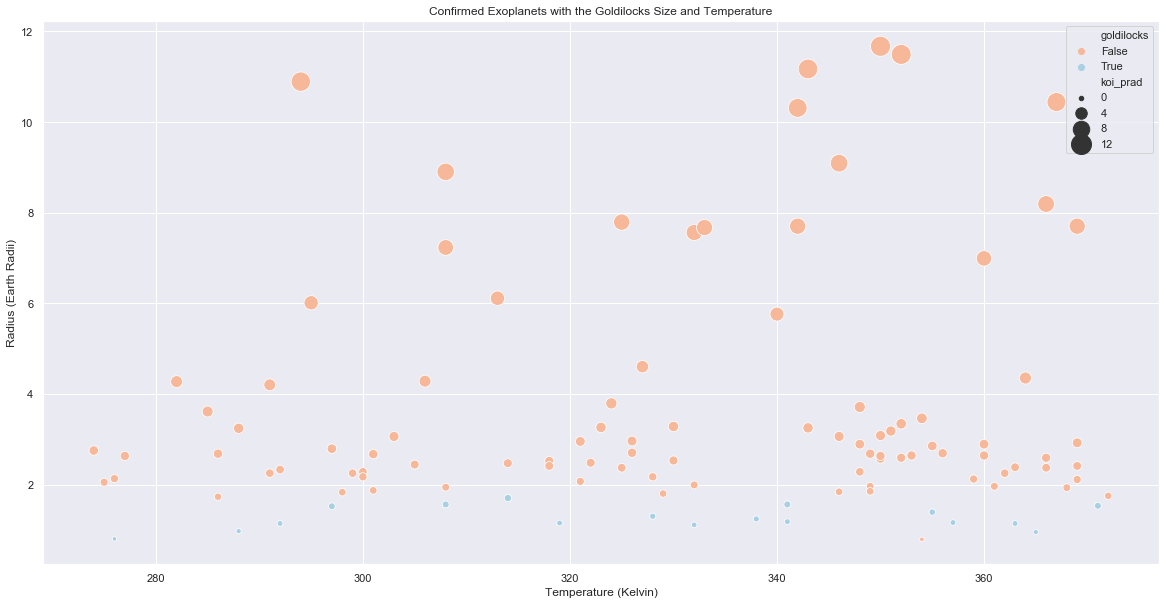

In [7]:
sns.set(rc={'figure.figsize':(20,10)})
sns.scatterplot(
    data=dataset.query('goldilocks_temp==True'),        
    x="koi_teq",
    y="koi_prad",
    size="koi_prad", sizes=(20,400),    
    hue="goldilocks", palette="RdBu",
)
plt.title('Confirmed Exoplanets with the Goldilocks Size and Temperature')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Radius (Earth Radii)')
display()

# Different Types of Goldilocks Exoplanet

This is the list of Goldilocks Exoplanets

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(   "Number of potentually habitable exoplanets: " + str(dataset.query('goldilocks==True').shape[0]) )
    display( dataset.query('goldilocks==True') )

Number of potentually habitable exoplanets: 17


,kepler_name,koi_disposition,ra,dec,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_fittype,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff1,koi_ldm_coeff2,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sparprov,goldilocks_temp,goldilocks_size,goldilocks
kepoi_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
K00494.01,Kepler-577 b,CONFIRMED,294.71194,39.073761,25.695815,188.788890,2455021.789,0.680,4.0251,1130.8,0.032548,1.56084,LS+MCMC,1.70,0.1348,88.97,314.0,2.30,37.90,0.2631,0.4260,3787.0,4.775,-0.22,0.477,0.496,stellar,True,True,True
K00571.04,Kepler-186 e,CONFIRMED,298.65271,43.955021,22.407778,153.798580,2454986.799,0.147,3.2881,661.3,0.023714,5.52889,LS+MCMC,1.15,0.1194,89.84,319.0,2.44,52.75,0.2405,0.4418,3751.0,4.800,-0.34,0.443,0.452,stellar,True,True,True
K02311.03,Kepler-1185 b,CONFIRMED,287.24118,39.332760,104.351962,190.102610,2455023.103,0.532,3.6950,243.8,0.014651,11.24570,LS+MCMC,1.39,0.4297,89.84,355.0,3.74,186.40,0.4035,0.2622,5650.0,4.546,0.02,0.870,0.971,stellar,True,True,True
K03284.01,Kepler-438 b,CONFIRMED,281.64581,41.951092,35.233069,135.364770,2454968.365,0.139,3.6740,352.8,0.016941,6.12686,LS+MCMC,0.97,0.1729,89.89,288.0,1.62,73.80,0.5308,0.2107,3749.0,4.743,0.16,0.524,0.554,stellar,True,True,True
K03255.01,Kepler-437 b,CONFIRMED,297.34738,44.026939,66.650452,171.182290,2455004.182,0.433,5.7440,536.9,0.020972,2.34630,LS+MCMC,1.56,0.2875,89.70,308.0,2.14,82.00,0.6811,0.0672,4550.0,4.627,0.00,0.679,0.713,stellar,True,True,True
K03497.01,Kepler-1512 b,CONFIRMED,289.27451,44.470322,20.359719,134.291230,2454967.291,0.925,2.1521,345.7,0.021227,1.40140,LS+MCMC,0.80,0.1025,88.31,276.0,1.38,31.30,0.3573,0.3660,3419.0,4.904,0.04,0.344,0.346,stellar,True,True,True
K00719.03,Kepler-220 e,CONFIRMED,291.50616,46.895741,45.902977,166.556670,2454999.557,0.303,5.0041,361.8,0.016968,2.82700,LS+MCMC,1.18,0.2166,89.74,341.0,3.19,68.00,0.6584,0.0833,4499.0,4.635,-0.26,0.639,0.643,stellar,True,True,True
K02173.02,Kepler-367 c,CONFIRMED,297.29242,49.981628,53.578305,171.185700,2455004.186,0.769,5.1940,224.9,0.015126,0.93643,LS+MCMC,1.16,0.2543,89.16,357.0,3.82,52.20,0.6270,0.1082,4856.0,4.624,0.00,0.705,0.790,stellar,True,True,True
K02650.01,Kepler-395 c,CONFIRMED,293.51108,45.136589,34.989785,144.209120,2454977.209,0.034,4.2080,498.5,0.020074,4.19621,LS+MCMC,1.14,0.1691,89.97,292.0,1.71,64.76,0.4224,0.3037,3765.0,4.725,0.02,0.521,0.526,stellar,True,True,True


#### Orbital Distance vs Stellar Mass
Plotting the Goldilocks Exoplanets against Stellar Mass and Orbital Distance.

There is a strong linear correlation between the Stellar Mass (and by extension Surface Temperature), with the Orbital Radius of the Habitable Zone

Within the correlation, there still appears to be 4 distinct clusters, possibly indicating different classes of [Red Dwarfs](https://en.wikipedia.org/wiki/Red_dwarf) and [Main Sequence](https://en.wikipedia.org/wiki/Main_sequence) stars

In [9]:
from sklearn.cluster import KMeans
df = dataset.query('goldilocks==True')
df['kmeans_sma_smass'] = (
    KMeans(n_clusters=4)
        .fit_predict(df[['koi_sma','koi_smass']])
)
df

/Users/jamie/Dropbox/Programming/Kaggle/dataset-kepler/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,kepler_name,koi_disposition,ra,dec,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_fittype,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff1,koi_ldm_coeff2,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sparprov,goldilocks_temp,goldilocks_size,goldilocks,kmeans_sma_smass
kepoi_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
K00494.01,Kepler-577 b,CONFIRMED,294.71194,39.073761,25.695815,188.788890,2455021.789,0.680,4.0251,1130.8,0.032548,1.56084,LS+MCMC,1.70,0.1348,88.97,314.0,2.30,37.90,0.2631,0.4260,3787.0,4.775,-0.22,0.477,0.496,stellar,True,True,True,0
K00571.04,Kepler-186 e,CONFIRMED,298.65271,43.955021,22.407778,153.798580,2454986.799,0.147,3.2881,661.3,0.023714,5.52889,LS+MCMC,1.15,0.1194,89.84,319.0,2.44,52.75,0.2405,0.4418,3751.0,4.800,-0.34,0.443,0.452,stellar,True,True,True,0
K02311.03,Kepler-1185 b,CONFIRMED,287.24118,39.332760,104.351962,190.102610,2455023.103,0.532,3.6950,243.8,0.014651,11.24570,LS+MCMC,1.39,0.4297,89.84,355.0,3.74,186.40,0.4035,0.2622,5650.0,4.546,0.02,0.870,0.971,stellar,True,True,True,3
K03284.01,Kepler-438 b,CONFIRMED,281.64581,41.951092,35.233069,135.364770,2454968.365,0.139,3.6740,352.8,0.016941,6.12686,LS+MCMC,0.97,0.1729,89.89,288.0,1.62,73.80,0.5308,0.2107,3749.0,4.743,0.16,0.524,0.554,stellar,True,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K00314.02,Kepler-138 d,CONFIRMED,290.38150,43.292988,23.089022,171.007634,2455004.008,0.320,1.7012,598.3,0.022578,36.24543,LS+MCMC,1.24,0.1264,89.82,338.0,3.10,100.70,0.3402,0.3719,3846.0,4.738,-0.24,0.503,0.505,stellar,True,True,True,0
K02704.01,Kepler-445 c,CONFIRMED,298.73611,46.498634,4.871224,133.642550,2454966.643,0.706,1.5916,6462.0,0.079431,5.56558,LS+MCMC,1.56,0.0301,87.88,341.0,3.18,19.11,0.4230,0.3107,3157.0,5.112,0.26,0.180,0.153,stellar,True,True,True,1
K00248.04,Kepler-49 e,CONFIRMED,292.29459,40.591789,18.596115,141.263310,2454974.263,0.014,2.3052,813.8,0.025959,13.82558,LS+MCMC,1.53,0.1120,89.99,371.0,4.48,63.23,0.4224,0.3037,3834.0,4.708,-0.02,0.539,0.541,stellar,True,True,True,0
K00899.03,Kepler-249 d,CONFIRMED,296.98505,43.658520,15.368457,147.389650,2454980.390,0.115,2.4714,756.1,0.024710,9.06854,LS+MCMC,1.11,0.0922,89.86,332.0,2.86,48.38,0.3573,0.3660,3561.0,4.855,0.00,0.411,0.440,stellar,True,True,True,0


/Users/jamie/Dropbox/Programming/Kaggle/dataset-kepler/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


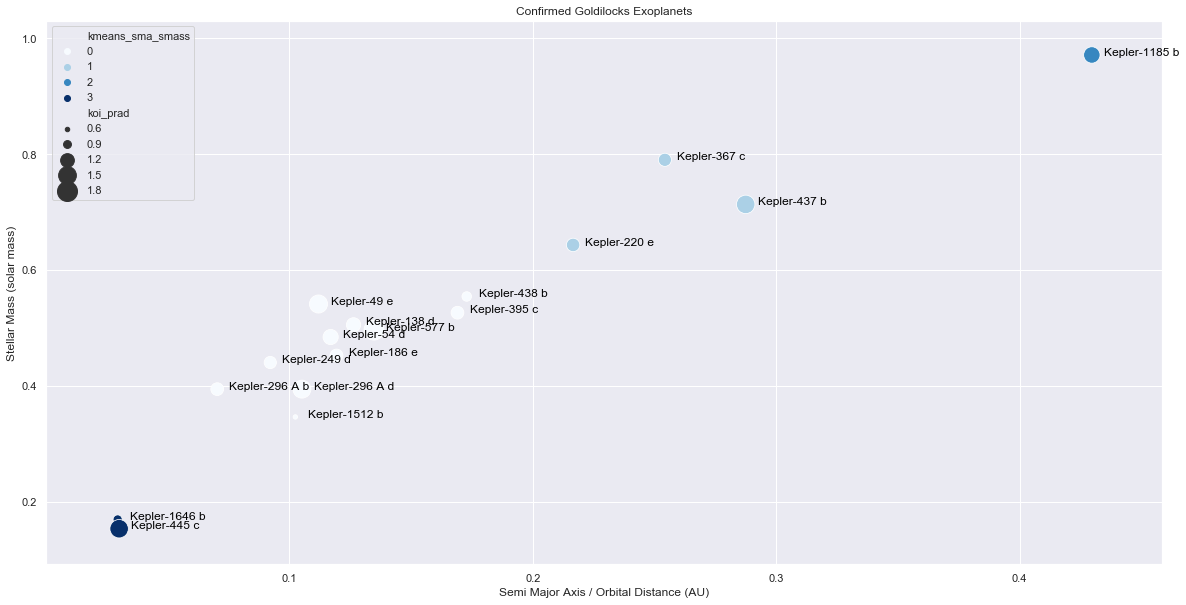

In [10]:
df = dataset.query('goldilocks==True')
df['kmeans_sma_smass'] = KMeans(n_clusters=4).fit_predict(df[['koi_sma','koi_smass']])

plot = sns.scatterplot(
    data=df,        
    x="koi_sma",
    y="koi_smass",

    size="koi_prad", sizes=(20,400),    
    hue="kmeans_sma_smass", palette="Blues",
#     hue="koi_teq", palette="RdBu_r",
)
for line in range(0,df.shape[0]):
     plot.text(
         df['koi_sma'][line]+0.005, 
         df['koi_smass'][line], 
         df['kepler_name'][line], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         # weight='semibold'
     )

plt.title('Confirmed Goldilocks Exoplanets')
plt.xlabel('Semi Major Axis / Orbital Distance (AU)')
plt.ylabel('Stellar Mass (solar mass)')
display()

#### Planetary Radius vs Stellar Metallicity

Plotting Planetary Radius against Stellar Metallicity, may provide insight groupings into planet composition, 
as high-metal stars are more likely to form rocky planets, rather than water/ice worlds or carbon planets

/Users/jamie/Dropbox/Programming/Kaggle/dataset-kepler/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


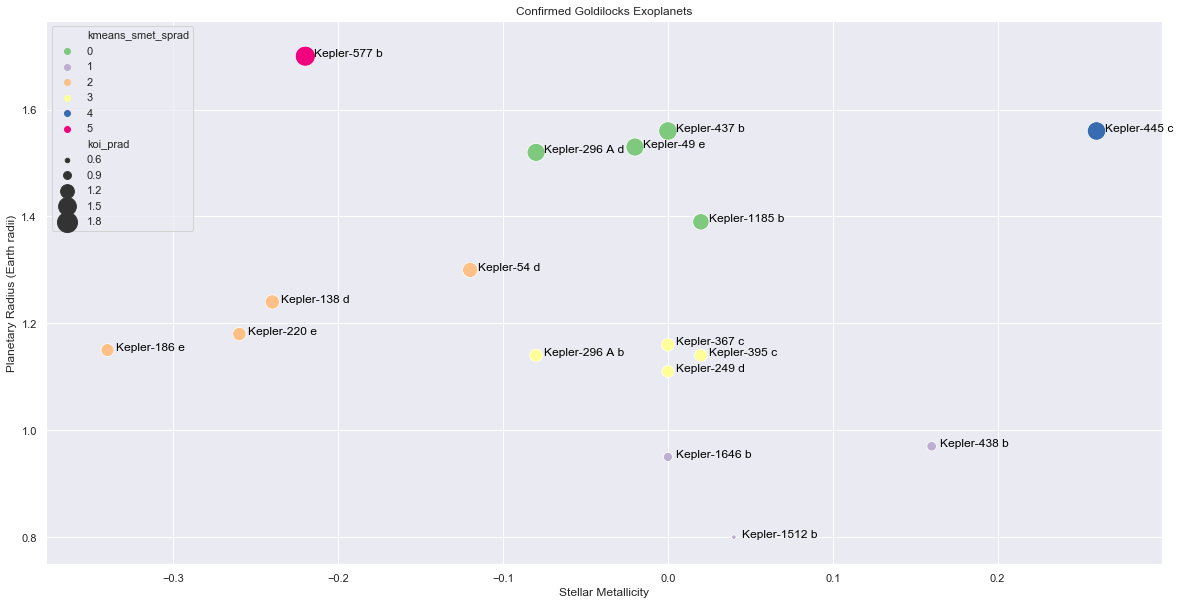

In [11]:
df = dataset.query('goldilocks==True')
df['kmeans_smet_sprad'] = KMeans(n_clusters=6).fit_predict(df[['koi_smet','koi_prad']])

plot = sns.scatterplot(
    data=df,        
    x="koi_smet",
    y="koi_prad",

    size="koi_prad", sizes=(20,400),    
    hue="kmeans_smet_sprad", palette="Accent",
)
for line in range(0,df.shape[0]):
     plot.text(
         df['koi_smet'][line]+0.005, 
         df['koi_prad'][line], 
         df['kepler_name'][line], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         # weight='semibold'
     )

plt.title('Confirmed Goldilocks Exoplanets')
plt.xlabel('Stellar Metallicity')
plt.ylabel('Planetary Radius (Earth radii)')
display()

# Starmap

Location of goldilocks exoplanets in the night sky

In [ ]:
display(
    sns.scatterplot(
        data=dataset,
        x="ra", 
        y="dec",
        sizes=(200,20),
        size="goldilocks", 
        hue="goldilocks", palette="hot",
    )
)